08/2017 

A. Gentile

### attempting to learn from simulations the parameters in the analytical model for Hahn echo signal experiments

inferring T2 and Larmour precession as metric objectives


## Library uploading

In [1]:
%matplotlib inline

import qinfer as qi
#import qutip as qt
import numpy as np
import scipy as sp
from IPython.display import display, Math, Latex
from functools import partial
import matplotlib.pyplot as plt
import importlib as imp

In [2]:
import datetime
import os as os
import time as time

In [3]:
import logging as logging
import sys

%run LoggingCode.py

In [4]:
# tell the user where files will be saved
dire = os.getcwd()
dire = dire+"/test_results/"
dire = os.path.normpath(dire)
print('Files will be saved in:')
print(dire)

Files will be saved in:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results


In [5]:
# Add personalized library to PYTHONPATH
sys.path.append(os.path.join("..","Libraries","QML_lib"))
sys.path.append(os.path.join(".."))

In [6]:
import warnings as warnings

""" filter only the Weight Clipping warning """
#SET LEVEL WARNINGS TO 0 In FINAL VERSION
warnings.filterwarnings("ignore", message='Negative weights occured', category=RuntimeWarning)

In [7]:
datadir=os.path.join("..","..","..","Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho02_second_tauequtaudeg")

import SETTINGS as SETTINGS
SETTINGS.init('signal', datadir)

from Norms import *
from IOfuncts import *
from EvalLoss import *

import ProbeStates as pros
import multiPGH as mpgh
import HahnSimQMD as gsi
import Evo as evo
import Distrib as distr
import HahnTheoModels as HTM

For this run I am using data in directory: 
..\..\..\Hamiltonian Learning With Seb\Decoherence_learning\NV05_HahnEcho02_second_tauequtaudeg


..\SETTINGS.py:67: UserWarning: Remember to set the correct parameters in the SETTINGS.PY
  warnings.warn("Remember to set the correct parameters in the SETTINGS.PY")


## Reload when needed

In [69]:
imp.reload(pros)
imp.reload(mpgh)
imp.reload(gsi)
imp.reload(evo)
imp.reload(distr)
imp.reload(SETTINGS)   #reload 2x if raises errors

<module 'SETTINGS' from '..\\SETTINGS.py'>

# Choose model & parameters

## Data import

In [ ]:
"""Just a reasonable guess to see how things go"""
 
true_params = np.array([[0.39, 0.01, 29.7*10**-3]])#, 0.5]])
sigmas = np.array([0.1, 0.005, 10*10**-3])#, 0.05])
scramble = np.array([0.1, 0.0025, 5*10**-3])#, 0.05])

In [ ]:
"""Enlarging the prior (works well for mean and sigma, not as much for delta... because in our modelling secondary peaks are
highly suppressed (learning their positions would require the frequencies to be estimated singularly instead of sampled)"""
 
true_params = np.array([[0.39, 10*10**-3, 29.7*10**-3]])#, 0.5]])
sigmas = np.array([0.2, 20*10**-3, 100*10**-3])#, 0.05])
scramble = np.array([0.2, 20*10**-3, 100*10**-3])#, 0.05]) 

In [ ]:
boundaries = np.array([ [0,1], [0, 0.3], [0, 1]])#, [0.4,0.6]  ])
np.all(true_params > boundaries[:,0], axis=1) and np.all(true_params < boundaries[:,1], axis=1)

# Results from QLE trivial step-by-step implementation

In [236]:
# Prior obtained from testFinEstimParams at the end of the QMD phase

prior = distr.MultiVariateNormalDistributionNocov(len(true_params[0]), mean = true_params[0]+scramble, sigmas = sigmas)

In [237]:
prior.sample()

array([[ 0.69982533,  0.49316556]])

run from __"Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho02"___

In [238]:
invertize=False
trotterize=False
model = gsi.HahnSignalAnaSimQMD(modelparams=true_params, Nqubit_interact = 25, bound_params = boundaries,  
                      IQLE=invertize, datasource = 'sim')

n_particles = 100
n_experiments = 200

# higher resample_threshold -> higher frequency of resampling
# higher a in LiuWest -> less "data scrambling", slower learning
updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.6, resampler = qi.LiuWestResampler(a=0.9), debug_resampling=True)

#IQLE already works well with resample_thresh=0.6, resampler = qi.LiuWestResampler(a=0.8)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, inv_field=inv_field)
experiment = heuristic()
print('Heuristic output:' + repr(experiment))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Inversion fields are: ['w_1', 'w_2']
Heuristic output:array([(2.502267655723492, 0.571488507769038, 0.4055765893710456)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8')])
Initialization Ready


datum = model.simulate_experiment(true_params, experiment)
#print(repr(datum))

updater.update(datum, experiment)

In [239]:
start = time.clock()

# probecounter for the choice of the state
probecounter = 0


track_eval = np.empty([n_experiments,len(true_params[0])])
track_loss = np.empty(n_experiments)
track_cov = np.empty(n_experiments)
track_time = np.empty(n_experiments)

track_particle_locs = np.empty([n_particles, len(true_params[0]), n_experiments])
track_particle_wght = np.empty([n_particles, n_experiments])

resample_events = []


for idx_experiment in range(n_experiments):
    
    experiment = heuristic()
    experiment[0][0] = 1.27*experiment[0][0]
    #print('Chosen experiment: ' + repr(experiment))
    
    if idx_experiment == 0:
        print('Initial time selected > ' + str(experiment[0][0]))
    if idx_experiment == n_experiments-1:
        print('Final time selected > ' + str(experiment[0][0]))
    
    track_time[idx_experiment] = experiment[0][0]
    
    datum = model.simulate_experiment(true_params, experiment)
    #print('Extracted datum: ' + repr(datum))
    updater.update(datum, experiment)
    if updater._just_resampled == True:
        resample_events.append(idx_experiment)
    
#     heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)

    track_cov[idx_experiment] = np.linalg.norm(updater.est_covariance_mtx())
    
    track_particle_locs[:, :, idx_experiment] = updater.particle_locations
    track_particle_wght[:, idx_experiment] = updater.particle_weights

    new_eval = updater.est_mean()
    track_eval[idx_experiment] = new_eval
    
    new_loss = eval_loss(model, new_eval, true_params)
    track_loss[idx_experiment] = new_loss[0]
    
end = time.clock()

print("\n\nElapsed time:" + str(end-start) + " secs")

Initial time selected > 2.39287558765


qinfer.smc - DEBUG - Resampling changed mean by [-0.01044337 -0.00238313]. Norm change in cov: 0.004401316559799914.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00180021  0.0130861 ]. Norm change in cov: 0.0020864878818483276.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.0011067  -0.02297937]. Norm change in cov: 0.0012610914991520608.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00148088 -0.00614049]. Norm change in cov: 0.00019733350530670924.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00027618 -0.00243913]. Norm change in cov: 0.0004862149577925639.


Final time selected > 7.31738009377


Elapsed time:3.7954926018842343 secs


In [240]:
print("True parameters: ", str(true_params))
print("Last estimate of the parameters: ", str(new_eval))

True parameters:  [[ 0.39  0.5 ]]
Last estimate of the parameters:  [ 0.38208718  0.62274088]


In [241]:
[track_loss[0], track_loss[-1]]

[0.027472056910641411, 0.015127935294283416]

## Data plotting

In [230]:
timestamp = mytimestamp()
labelize = '_IQLE' if invertize == True else '_QLE'

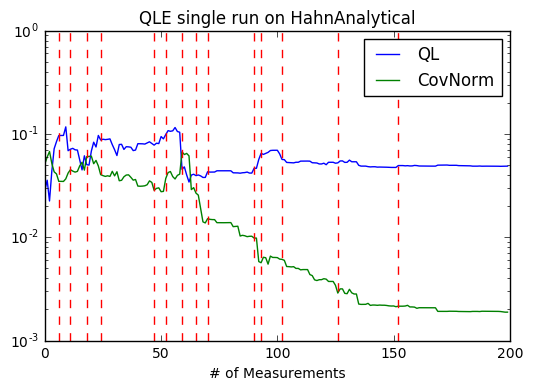

In [231]:
plt.semilogy(track_loss, label = 'QL')
plt.semilogy(track_cov, label = 'CovNorm')

for xc in resample_events:
    plt.axvline(x=xc, ls = '--', color = 'red')

plt.title("QLE single run on HahnAnalytical")
plt.xlabel('# of Measurements')
plt.legend()

thisfig = "_trackloss___"
filefigname = dire+"\\QLEsim_HahnAnalytical_Nparts_"+str(n_particles)+thisfig+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)
# print(filefigname)
# plt.savefig(filefigname)

plt.show()

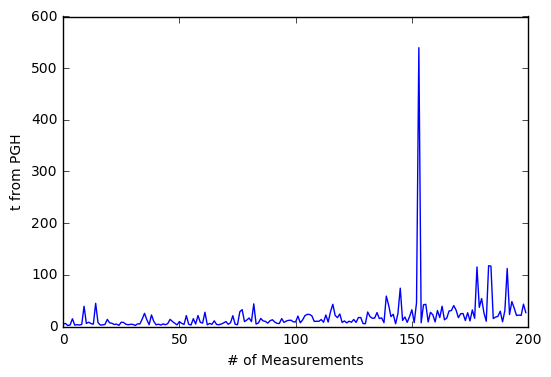

In [211]:
plt.plot(track_time)
plt.xlabel('# of Measurements')
plt.ylabel('t from PGH')

thisfig = "_tracktime___"

#print(filefigname)
#plt.savefig(filefigname)

plt.show()

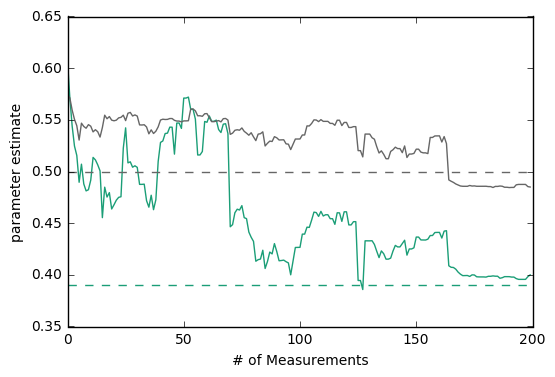

In [215]:
data_len = len(track_eval[0])
color_list = plt.cm.Dark2(np.linspace(0, 1, data_len)) 

for idx in range(data_len):
    plt.plot(track_eval[:,idx], color=color_list[idx], label='Param'+str(idx))
    plt.axhline(y = true_params[0][idx], ls= '--', color=color_list[idx])
    

plt.xlabel('# of Measurements')
plt.ylabel('parameter estimate')
# plt.legend()

thisfig = "_trackparams___"
# print(filefigname)
# plt.savefig(filefigname)

plt.show()

# Param sweeps

In [42]:
"""Just a reasonable guess to see how things go"""
 
true_params = np.array([[0.39, 0.01, 29.7*10**-3]])#, 0.5]])
sigmas = np.array([0.1, 0.005, 10*10**-3])#, 0.05])
scramble = np.array([0.1, 0.0025, 5*10**-3])#, 0.05])

In [20]:
invertize=False
trotterize=False
labelize = '_IQLE' if invertize == True else '_QLE'

allfilenames = dire+"\\GenSim_analytical_QLE_simTEST_ParSweep"+"_Nparts_"+str(n_particles)+"_Nparams_"+str(len(true_params[0]))

In [21]:
model = gsi.HahnSignalAnaSimQMD(modelparams=true_params, Nqubit_interact = 25, bound_params = boundaries,  
                     IQLE=invertize, datasource = 'sim')

n_particles = 100
n_experiments = 200

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Initialization Ready


In [22]:
n_trials = 50
n_param = 10

start = time.clock()

track_loss = np.empty([n_param, n_trials, n_experiments])

# param_sweep = np.linspace(0.35, 0.75, n_param) # resample threshold, optimal ~ 0.55 *with a 0.92*
# param_sweep = np.linspace(0.8, 0.95, n_param) # a, optimal ~ 0.9
param_sweep = np.linspace(0.3, 1, n_param) # a, optimal ~ 0.85

for param in range(n_param):

    for trial in range(n_trials):

        prior = distr.MultiVariateNormalDistributionNocov(len(true_params[0]), mean = true_params[0]+scramble, sigmas = sigmas)
        updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.55, resampler = qi.LiuWestResampler(a=0.9), debug_resampling=False)
        heuristic = mpgh.multiPGH(updater, inv_field=inv_field)

        for idx_experiment in range(n_experiments):

            experiment = heuristic()
            experiment[0][0] = param_sweep[param]*experiment[0][0]

            datum = model.simulate_experiment(true_params, experiment)
            updater.update(datum, experiment)
        #     heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
            new_loss = eval_loss(model, updater.est_mean(), true_params)
            track_loss[param, trial, idx_experiment] = new_loss[0]

    print("Done parameter " + str(param_sweep[param]))
    
end = time.clock()

print("\n\nElapsed time:" + str(end-start) + " secs")

Done parameter 0.3
Done parameter 0.377777777778
Done parameter 0.455555555556
Done parameter 0.533333333333
Done parameter 0.611111111111
Done parameter 0.688888888889
Done parameter 0.766666666667
Done parameter 0.844444444444
Done parameter 0.922222222222
Done parameter 1.0


Elapsed time:1617.6915607782998 secs


## Plots - param sweep

In [23]:
timestamp = mytimestamp()
thisfig = "_pghfactor___"

from matplotlib import cm
cm_subsection = np.linspace(0, 1, n_param) 
colors = [ cm.jet(x) for x in cm_subsection ]

Data saving in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\GenSim_analytical_QLE_simTEST_ParSweep_Nparts_200_Nparams_3_pghfactor____2017-08-29_20.13.58.pdf


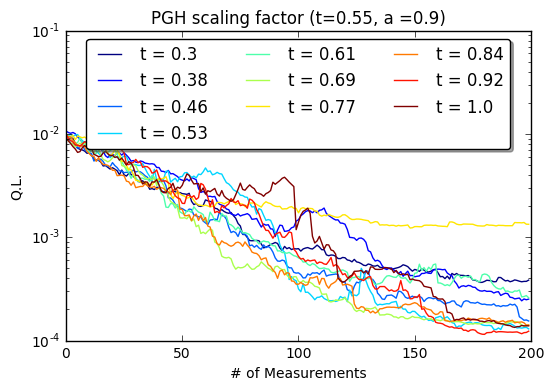

In [24]:
for param in range(n_param):
    meanQL = np.mean(track_loss[param], axis = 0)
    plt.semilogy(meanQL, color = colors[param], label = "t = " + str(np.around(param_sweep[param], 2) ) )

plt.title('PGH scaling factor (t=0.55, a =0.9)')
plt.xlabel('# of Measurements')
plt.ylabel('Q.L.')
plt.legend()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, shadow=True)

filefigname = allfilenames+thisfig+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)
print('Data saving in\n'+filefigname)
plt.savefig(filefigname)

plt.show()

In [1508]:
timestamp = mytimestamp()
thisfig = "_a___"

Data saving in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\GenSim_analytical_QLE_simTEST_ParSweep_Nparts_200_Nparams_3_resthresh____2017-08-29_18.09.04.pdf


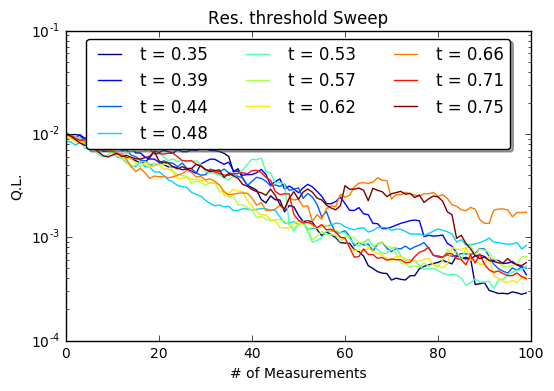

In [1510]:
for param in range(n_param):
    meanQL = np.mean(track_loss[param], axis = 0)
    plt.semilogy(meanQL, color = colors[param], label = "t = " + str(np.around(param_sweep[param], 2) ) )

plt.title('Res. threshold Sweep')
plt.xlabel('# of Measurements')
plt.ylabel('Q.L.')
plt.legend()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, shadow=True)

filefigname = allfilenames+thisfig+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)
print('Data saving in\n'+filefigname)
plt.savefig(filefigname)

plt.show()

# Multiple tests

In [86]:
invertize=False
trotterize=False
model = gsi.HahnSignalAnaSimQMD(modelparams=true_params, Nqubit_interact = 25, bound_params = boundaries,  
                     IQLE=invertize, datasource = 'sim')

n_particles = 100
n_experiments = 200

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Initialization Ready


In [87]:
n_trials = 500

start = time.clock()

track_loss = np.empty([n_trials,n_experiments])
track_eval = np.empty([n_trials,n_experiments,len(true_params[0])])
track_cov = np.empty([n_trials,n_experiments])
track_stdev = np.empty([n_trials,n_experiments,len(true_params[0])])
track_time = np.empty([n_trials,n_experiments])

for trial in range(n_trials):
    
    prior = distr.MultiVariateNormalDistributionNocov(len(true_params[0]), mean = true_params[0]+scramble, sigmas = sigmas)
    updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.55, resampler = qi.LiuWestResampler(a=0.9), debug_resampling=False)
    heuristic = mpgh.multiPGH(updater, inv_field=inv_field)

    for idx_experiment in range(n_experiments):

        experiment = heuristic()
        experiment[0][0] = 0.7*experiment[0][0]
        track_time[trial, idx_experiment] = experiment[0][0]

        datum = model.simulate_experiment(true_params, experiment)
        updater.update(datum, experiment)
    #     heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
        
        track_cov[trial,idx_experiment] = np.linalg.norm(updater.est_covariance_mtx())
        track_stdev[trial,idx_experiment] = np.diag(updater.est_covariance_mtx())

        new_eval = updater.est_mean()
        track_eval[trial,idx_experiment] = new_eval
        
        new_loss = eval_loss(model, new_eval, true_params)
        track_loss[trial, idx_experiment] = new_loss[0]
    
    if trial%10 == 0:
        print("Done iteration " + str(trial))
    
end = time.clock()

print("\n\nElapsed time:" + str(end-start) + " secs")

Done iteration 0
Done iteration 10
Done iteration 20
Done iteration 30
Done iteration 40
Done iteration 50
Done iteration 60
Done iteration 70
Done iteration 80
Done iteration 90
Done iteration 100
Done iteration 110
Done iteration 120
Done iteration 130
Done iteration 140
Done iteration 150
Done iteration 160


C:\Program Files\Anaconda3\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 1 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Done iteration 170
Done iteration 180
Done iteration 190
Done iteration 200
Done iteration 210
Done iteration 220
Done iteration 230
Done iteration 240
Done iteration 250
Done iteration 260
Done iteration 270
Done iteration 280
Done iteration 290
Done iteration 300
Done iteration 310
Done iteration 320
Done iteration 330
Done iteration 340
Done iteration 350
Done iteration 360
Done iteration 370
Done iteration 380
Done iteration 390
Done iteration 400
Done iteration 410
Done iteration 420
Done iteration 430
Done iteration 440
Done iteration 450
Done iteration 460
Done iteration 470
Done iteration 480
Done iteration 490


Elapsed time:1665.5353511878639 secs


## Data export - multiple tests

In [ ]:
allfilenames = dire+"\\GenSim_analytical_QLE_simTEST_Nruns_"+str(n_trials)+"_Nparts_"+str(n_particles)+"_Nparams_"+str(len(true_params[0]))

labelize = '_IQLE' if invertize == True else '_QLE'

In [11]:
import pickle as pickle
timestamp = mytimestamp()

thisfile = "_alldata___"
# thisfile = allfilenames+thisfile+timestamp+".dat"
print('Data saving in\n'+thisfile)

Data saving in
_alldata___


In [91]:
data = [track_eval, track_cov, track_stdev, track_time, track_loss]

with open(thisfile, "wb") as f:
    pickle.dump(data, f)

In [12]:
# Reload if OLDDATA are required
PIK = dire+"\\GenSim_analytical_QLE_simTEST_Nruns_1000_Nparts_100_Nparams_3_alldata____2017-08-29_15.24.14.dat"

with open(PIK, "rb") as f:
    dataold = pickle.load(f)
    
#prepare data
track_eval = dataold[0]
track_cov =  dataold[1]
track_stdev =  dataold[2]
track_time =  dataold[3]
track_loss =  dataold[4]

## Plots - multiple tests

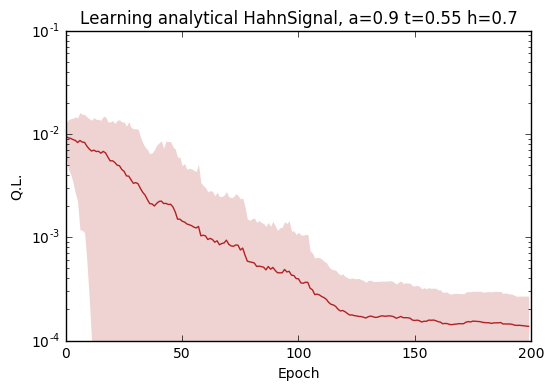

In [16]:
meanQL = np.mean(track_loss, axis = 0)
#errQL = np.mean(track_cov, axis = 0) 
errQL = np.std(track_loss, axis = 0)

steps = range(len(meanQL))

plt.semilogy(meanQL, color='firebrick')
plt.fill_between(steps, meanQL+errQL, [max(meanQL[i]-errQL[i], 10**-4) for i in steps],
    alpha=0.2, linewidth=0, facecolor='firebrick', antialiased=True)

plt.title('Learning analytical HahnSignal, a=0.9 t=0.55 h=0.7' )
plt.xlabel('Epoch')
plt.ylabel('Q.L.')

# thisfig = "_trackloss___"
# filefigname = allfilenames+thisfig+timestamp+".pdf"
# filefigname = os.path.normpath(filefigname)
# print(filefigname)
# plt.savefig(filefigname)

plt.show()

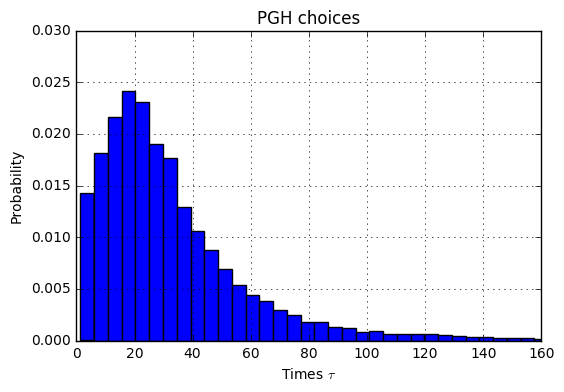

In [1474]:
# the histogram of the data
n, bins, patches = plt.hist(track_time.ravel(), 300, normed=1)

plt.xlabel(r'Times $\tau$')
plt.ylabel('Probability')
plt.title('PGH choices')
plt.axis([0, 160, 0, 0.03])
plt.grid(True)
plt.show()

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\GenSim_analytical_QLE_simTEST_Nruns_500_Nparts_100_Nparams_3_trackparams____2017-08-30_12.50.10.pdf


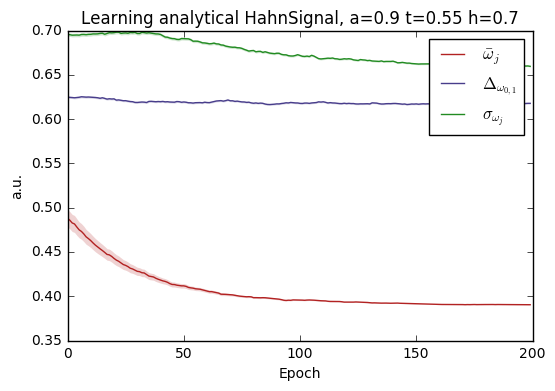

In [123]:
meaneval = np.mean(track_eval, axis = 0)
meanstdev = np.mean(track_stdev, axis = 0)

enhance1 = 50
enhance2 = 20

plt.plot(meaneval[:,0], 'k', label=r'$\bar{\omega}_j$', color='firebrick')
plt.fill_between(steps, meaneval[:,0]-meanstdev[:,0], meaneval[:,0]+meanstdev[:,0],
    alpha=0.2, linewidth=0, facecolor='firebrick', antialiased=True)

plt.plot(enhance1*meaneval[:,1], label=r'$\Delta_{\omega_{0,1}}$', color='darkslateblue')
plt.fill_between(steps, enhance1*(meaneval[:,1]-meanstdev[:,1]), enhance1*(meaneval[:,1]+meanstdev[:,1]),
    alpha=0.2, linewidth=0, facecolor='darkslateblue', antialiased=True)

plt.plot(enhance2*meaneval[:,2], label=r'$\sigma_{\omega_j}$', color='forestgreen')
plt.fill_between(steps, enhance2*(meaneval[:,2]-meanstdev[:,2]),enhance2*(meaneval[:,2]+meanstdev[:,2]),
    alpha=0.2, linewidth=0, facecolor='forestgreen', antialiased=True)

plt.title('Learning analytical HahnSignal, a=0.9 t=0.55 h=0.7' )
plt.xlabel('Epoch')
plt.ylabel('a.u.')
plt.legend()

thisfig = "_trackparams___"
filefigname = allfilenames+thisfig+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)

#UNCOMMENT TO SAVE PICTURE
print(filefigname)
plt.savefig(filefigname)

plt.show()

# Compare the average obtained parameters against the experimental dynamics

In [435]:
# Extract experimental data to plot

directory = os.path.join("..","..","..","Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho02")
moredata =  ImportAllFolder_Hahnpeak(directory, clean_duplicates = True)  

myrange = range(0, min(moredata.shape[0],500)) 

# the 1000 factor converts ns to us
moredata = [ [moredata[i,0]/1000 , moredata[i,1]] for i in myrange]
moredata = np.array(moredata)

offset = 0.18
moredata[:,0] = moredata[:,0]-offset

In [436]:
# Select a specific run of the simulations if needed
runID = 5

In [437]:
#Extract average (singular) values out of the simulations

testFinEstimParams = np.mean(track_eval[:][-1], axis=0)
#testFinEstimParams = track_eval[runID][-1]
myHfA = testFinEstimParams[0:3]
print(myHfA)
myBathfreq = testFinEstimParams[3:6]
print(myBathfreq)

[-2.85253252 -2.76159646 -2.12561744]
[ 0.65648023  0.43504202  0.54913253]


myHfA = [-2.89211754, -2.70041014, -2.01418793]
myBathfreq = [ 1,2,3]

Picture saved in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\CompareData_PostProcModel_noDeco_2017-08-23_13.12.42.pdf


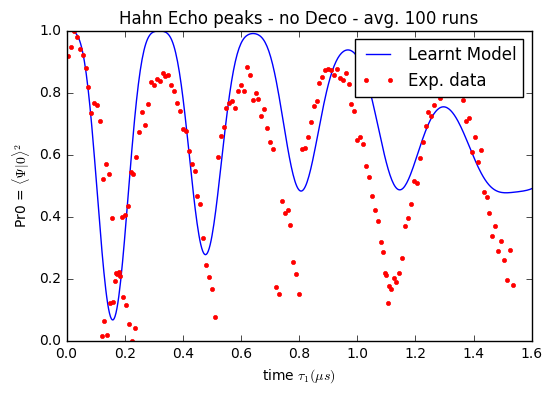

In [442]:
tvec = np.linspace(0.,1.6,500)

simdata = HTM.Q2_HF_Precession(tvec, HfA = myHfA, Bathfreq = myBathfreq)
plt.plot(tvec, simdata, "b-")

expdata = rescaledatatofullrange(moredata[:,1])
plt.plot(moredata[:,0], expdata, "r.")
plt.xlim([0,1.6])

plt.legend(('Learnt Model', 'Exp. data'))

plt.title(r'Hahn Echo peaks - no Deco - avg. 100 runs')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $')

filefigname = dire+"\CompareData_PostProcModel_noDeco"+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)
plt.savefig(filefigname)
print('Picture saved in\n'+filefigname)

plt.show()